In [ ]:
!pip install datasets transformers evaluate --q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Mon Nov 14 16:59:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Sexism Dataset

In [ ]:
import pandas as pd

df_train = pd.read_csv('drive/MyDrive/Group_3/train.csv')
df_val = pd.read_csv('drive/MyDrive/Group_3/test.csv')

In [ ]:
df_train

,text,label_sexist,label_category,label_vector
0,"""Peaceful Muslim Migrants"" gang rape 26 year o...",not sexist,none,none
1,Man watching this was so hard. I dont know how...,not sexist,none,none
2,My mother is not a slut and never was a slut. ...,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,..."
3,This is so embarrassing. A. he’s hitting on so...,sexist,2. derogation,2.2 aggressive and emotive attacks
4,"This. over 80% of men are ""betas"" or ""low-qual...",sexist,3. animosity,3.2 immutable gender differences and gender st...
...,...,...,...,...
7995,"If you're not attracted to her, don't go for her?",not sexist,none,none
7996,"Also it's not ""white nighting"" to go try to ta...",not sexist,none,none
7997,There is nothing to destroy.,not sexist,none,none
7998,just demonstrates the wild lack of agency wome...,sexist,2. derogation,2.1 descriptive attacks


# Task A: Binary Sexism Detection

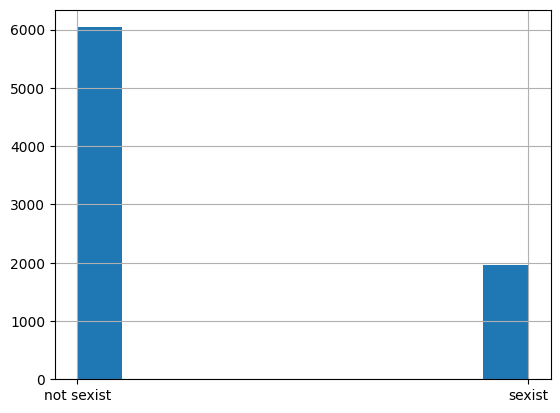

In [ ]:
import matplotlib.pyplot as plt

df_train['label_sexist'].hist()
plt.show()

In [ ]:
# Improve class balance

from tqdm.auto import tqdm
import numpy as np

df = df_train[df_train['label_sexist']=='sexist']

ndata = []

for _ in tqdm(range(4000)):

    i = np.random.randint(0,len(df))
    j = np.random.randint(0,len(df))

    if i == j:
        j = i+1

    ndata.append(df['text'].iloc[i]+' '+df['text'].iloc[j])

ndf = pd.DataFrame()
ndf['text'] = ndata + df_train['text'].tolist()
ndf['label_sexist'] = ['sexist' for _ in range(4000)] + df_train['label_sexist'].tolist()

  0%|          | 0/4000 [00:00<?, ?it/s]

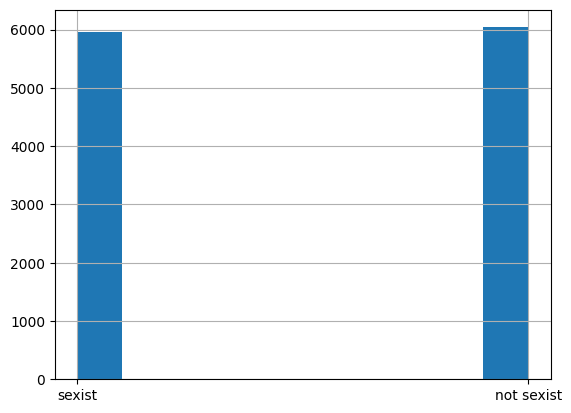

In [ ]:
ndf['label_sexist'].hist()

In [ ]:
label_map = {'not sexist':0, 'sexist':1}

train_df = pd.DataFrame()
train_df['text'] = df_train['text']
train_df['label'] = df_train['label_sexist'].map(label_map)

val_df = pd.DataFrame()
val_df['text'] = df_val['text']
val_df['label'] = df_val['label_sexist'].map(label_map)

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(train_df),
                      'val': Dataset.from_pandas(val_df)})

In [ ]:
dataset['train'][5]

{'text': "Women are the one's obsessed with identity politics! Everything is about genitals and skin color for women...",
 'label': 1}

In [ ]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizerA = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
def preprocess_function(examples):
    return tokenizerA(examples["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizerA)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
modelA = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

In [ ]:
modelA.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

In [ ]:
import evaluate
import numpy as np

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="drive/MyDrive/Project6/Task_A",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.1,
    evaluation_strategy='epoch'
)

trainerA = Trainer(
    model=modelA,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizerA,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainerA.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 66955010
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster th

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.461600,0.349743,0.850000,0.645390


Saving model checkpoint to drive/MyDrive/Project6/Task_A/checkpoint-500
Configuration saved in drive/MyDrive/Project6/Task_A/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Project6/Task_A/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/Project6/Task_A/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/Project6/Task_A/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=500, training_loss=0.4615720520019531, metrics={'train_runtime': 91.1782, 'train_samples_per_second': 87.74, 'train_steps_per_second': 5.484, 'total_flos': 126386317136448.0, 'train_loss': 0.4615720520019531, 'epoch': 1.0})

In [ ]:
trainerA.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


{'eval_loss': 0.3497425317764282,
 'eval_accuracy': 0.85,
 'eval_f1': 0.6453900709219859,
 'eval_runtime': 5.8436,
 'eval_samples_per_second': 342.256,
 'eval_steps_per_second': 21.391,
 'epoch': 1.0}

In [ ]:
predictions = trainerA.predict(tokenized_dataset["val"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(predictions.label_ids, preds))
print('F1_score =', f1_score(predictions.label_ids, preds))
print('Accuracy_score =', accuracy_score(predictions.label_ids, preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1531
           1       0.72      0.58      0.65       469

    accuracy                           0.85      2000
   macro avg       0.80      0.76      0.78      2000
weighted avg       0.84      0.85      0.84      2000

F1_score = 0.6453900709219859
Accuracy_score = 0.85


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

train_df0 = train_df[train_df['label']==0]
try:
    train_df0 = train_df0.drop(['level_0'], axis=1)
except:
    pass
train_df0 = train_df0.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df0['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df0['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df1 = train_df[train_df['label']==1]
try:
    train_df1 = train_df1.drop(['level_0'], axis=1)
except:
    pass
train_df1 = train_df1.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df1['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df1['label'][i]))
    except:
        continue

Weights given to word:
[('ur', 0.2733615524925241), ('old', 0.26688783678891376), ('migrants', 0.23595198945042176), ('muslim', 0.23353691454920072), ('26', 0.1744207006387758), ('polish', 0.1489643849917426), ('!', 0.1320328489842547), ('year', 0.102541979212875), ('##l', 0.10202928531578491), ('"', 0.08882595667771966)]
Class - 0
Weights given to word:
[('now', 0.43573968846679867), ('this', 0.2974554476869784), ('partner', 0.2013181830213439), ('wife', 0.19839711667221463), ('love', 0.18007229193482838), ('hard', 0.1721649607463575), ('this', 0.16008773826088454), ('for', 0.15791370782872177), ('obsessed', 0.1513541547578529), ('to', 0.15059012356221912)]
Class - 0
Weights given to word:
[('to', 0.2513083506590601), ('visiting', 0.21332667178798662), ('ya', 0.20075655425936245), ('up', 0.17016072409204952), ('know', 0.1572095194004347), ('to', 0.15612535982969147), ('mother', 0.1509503671669164), ('had', 0.13269818231721126), ('ya', 0.13000122033764377), ('needed', 0.119844853468153

# Task B: Category of Sexism

In [ ]:
taskB_train = df_train[df_train['label_category']!='none']
taskB_val = df_val[df_val['label_category']!='none']

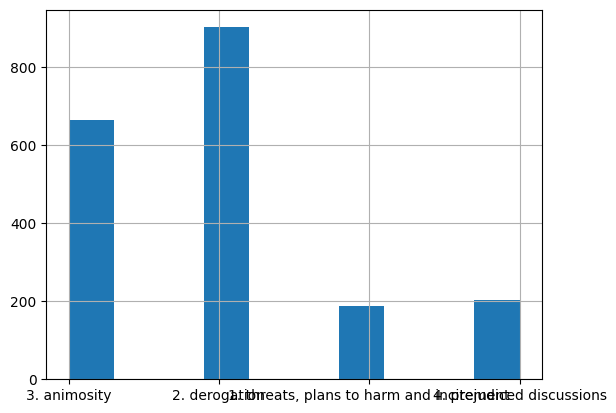

In [ ]:
import matplotlib.pyplot as plt

taskB_train['label_category'].hist()
plt.show()

In [ ]:
import numpy as np

labels = np.unique(taskB_train['label_category'])
labels

array(['1. threats, plans to harm and incitement', '2. derogation',
       '3. animosity', '4. prejudiced discussions'], dtype=object)

In [ ]:
label_map = {x:i for i,x in enumerate(labels)}

train_df = pd.DataFrame()
train_df['text'] = taskB_train['text']
train_df['label'] = taskB_train['label_category'].map(label_map)

val_df = pd.DataFrame()
val_df['text'] = taskB_val['text']
val_df['label'] = taskB_val['label_category'].map(label_map)

In [ ]:
len(train_df), len(val_df)

(1959, 469)

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(train_df),
                      'val': Dataset.from_pandas(val_df)})

In [ ]:
dataset['val'][5]

{'text': '[USER] Let\'s play this song and trigger the feminists, male and female, who (having no ideas) claim it\'s a song about "rape." Idiots.',
 'label': 3,
 '__index_level_0__': 11}

In [ ]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizerB = AutoTokenizer.from_pretrained("roberta-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_toke

In [ ]:
def preprocess_function(examples):
    return tokenizerB(examples["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

  0%|          | 0/1959 [00:00<?, ?ex/s]

  0%|          | 0/469 [00:00<?, ?ex/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizerB)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
modelB = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": t

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/pytorch_model.bin
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

In [ ]:
import evaluate
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_preds):
    # metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(predictions,labels, average='weighted')
    acc = accuracy_score(predictions,labels)
    return {'f1':f1, 'acc':acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="drive/MyDrive/Project6/Task_B",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainerB = Trainer(
    model=modelB,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizerB,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainerB.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1959
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 492
  Number of trainable parameters = 124648708
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the 

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.971603,0.559876,0.522388
2,No log,0.886183,0.621557,0.603412
3,No log,0.950622,0.600911,0.594883
4,No log,0.938437,0.626482,0.618337


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 469
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 469
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.f

TrainOutput(global_step=492, training_loss=0.8143050651240155, metrics={'train_runtime': 110.5901, 'train_samples_per_second': 70.856, 'train_steps_per_second': 4.449, 'total_flos': 240316694971080.0, 'train_loss': 0.8143050651240155, 'epoch': 4.0})

In [ ]:
trainerB.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 469
  Batch size = 16


{'eval_loss': 0.9384369850158691,
 'eval_f1': 0.6264821925348467,
 'eval_acc': 0.6183368869936035,
 'eval_runtime': 1.7134,
 'eval_samples_per_second': 273.72,
 'eval_steps_per_second': 17.509,
 'epoch': 4.0}

In [ ]:
predictions = trainerB.predict(tokenized_dataset["val"])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 469
  Batch size = 16


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(predictions.label_ids, preds))
print('F1_score =', f1_score(predictions.label_ids, preds, average='weighted'))
print('Accuracy_score =', accuracy_score(predictions.label_ids, preds))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        33
           1       0.62      0.76      0.68       218
           2       0.60      0.44      0.51       171
           3       0.58      0.60      0.59        47

    accuracy                           0.62       469
   macro avg       0.63      0.61      0.61       469
weighted avg       0.62      0.62      0.61       469

F1_score = 0.61019158145236
Accuracy_score = 0.6183368869936035


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

train_df0 = train_df[train_df['label']==0]
try:
    train_df0 = train_df0.drop(['level_0'], axis=1)
except:
    pass
train_df0 = train_df0.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df0['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df0['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df1 = train_df[train_df['label']==1]
try:
    train_df1 = train_df1.drop(['level_0'], axis=1)
except:
    pass
train_df1 = train_df1.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df1['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df1['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df2 = train_df[train_df['label']==2]
try:
    train_df2 = train_df2.drop(['level_0'], axis=1)
except:
    pass
train_df2 = train_df2.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df2['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df2['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df3 = train_df[train_df['label']==3]
try:
    train_df3 = train_df3.drop(['level_0'], axis=1)
except:
    pass
train_df3 = train_df3.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df3['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df3['label'][i]))
    except:
        continue

Weights given to word:
[('seek', 0.652063707569625), ('nirvana', 0.4210164639161005), ('!', 0.18473620028234108), ('heroin', 0.05361904680502502), ('[CLS]', 0.0), ('[SEP]', 0.0), ('should', -0.019671897221904988), ('!', -0.08528650829224058), ('in', -0.14470861717205616), ('!', -0.16429256255619973)]
Class - 0
Weights given to word:
[('##ag', 0.18034841244229743), ('name', 0.1642520019741399), ('!', 0.11014701623229457), ('and', 0.1038504844745557), ('or', 0.098384684432636), ('!', 0.09283523709369233), ('trust', 0.058131829545341754), ('us', 0.055047867940202826), ('whereabouts', 0.05157667380714707), ('!', 0.049787432009520315)]
Class - 0
Weights given to word:
[('women', 0.871103723672452), ('men', 0.30862588387886725), ('baby', 0.22425773818666034), ('on', 0.11311513013817996), ('plan', 0.05098914743345153), ('will', 0.04596862271290657), ('b', 0.036310405719972884), ('##te', 0.03521967912191507), ('schedule', 0.018243461711913732), ('is', 0.004114360259074213)]
Class - 0
Weights g

# Task C: Fine-grained Vector of Sexism

In [ ]:
taskC = df_train[df_train['label_category']!='none']

In [ ]:
labels = np.unique(df['label_category'])

labels

array(['1. threats, plans to harm and incitement', '2. derogation',
       '3. animosity', '4. prejudiced discussions'], dtype=object)

In [ ]:
taskC1_train = df_train[df_train['label_category']==labels[0]]
taskC2_train = df_train[df_train['label_category']==labels[1]]
taskC3_train = df_train[df_train['label_category']==labels[2]]
taskC4_train = df_train[df_train['label_category']==labels[3]]

taskC1_val = df_val[df_val['label_category']==labels[0]]
taskC2_val = df_val[df_val['label_category']==labels[1]]
taskC3_val = df_val[df_val['label_category']==labels[2]]
taskC4_val = df_val[df_val['label_category']==labels[3]]

## Part 1

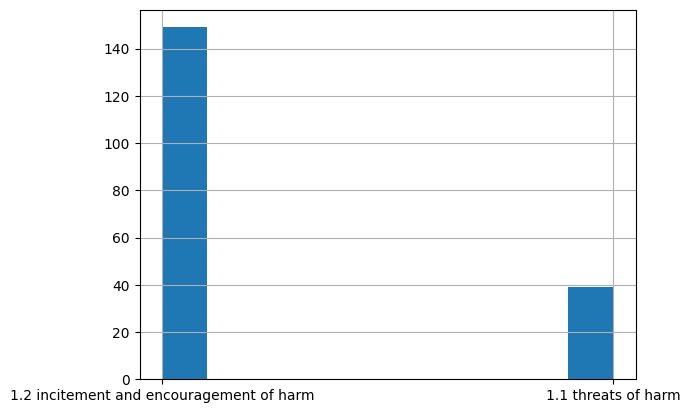

In [ ]:
import matplotlib.pyplot as plt

taskC1_train['label_vector'].hist()
plt.show()

In [ ]:
labels = np.unique(taskC1_train['label_vector'])
labels

array(['1.1 threats of harm', '1.2 incitement and encouragement of harm'],
      dtype=object)

In [ ]:
label_map = {x:i for i,x in enumerate(labels)}

train_df = pd.DataFrame()
train_df['text'] = taskC1_train['text']
train_df['label'] = taskC1_train['label_vector'].map(label_map)

val_df = pd.DataFrame()
val_df['text'] = taskC1_val['text']
val_df['label'] = taskC1_val['label_vector'].map(label_map)

In [ ]:
len(train_df), len(val_df)

(188, 33)

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(train_df),
                      'val': Dataset.from_pandas(val_df)})

In [ ]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizerC1 = AutoTokenizer.from_pretrained("roberta-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

In [ ]:
def preprocess_function(examples):
    return tokenizerC1(examples["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

  0%|          | 0/188 [00:00<?, ?ex/s]

  0%|          | 0/33 [00:00<?, ?ex/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizerC1)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
modelC1 = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/pytorch_

In [ ]:
import evaluate
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_preds):
    # metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(predictions,labels, average='weighted')
    acc = accuracy_score(predictions,labels)
    return {'f1':f1, 'acc':acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="drive/MyDrive/Project6/Task_C/Part_1",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainerC1 = Trainer(
    model=modelC1,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizerC1,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainerC1.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 188
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 60
  Number of trainable parameters = 124647170
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.470174,0.900000,0.818182
2,No log,0.432161,0.900000,0.818182
3,No log,0.468080,0.900000,0.818182
4,No log,0.453961,0.900000,0.818182
5,No log,0.445117,0.900000,0.818182


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 33
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 33
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.for

TrainOutput(global_step=60, training_loss=0.4967946688334147, metrics={'train_runtime': 13.9632, 'train_samples_per_second': 67.32, 'train_steps_per_second': 4.297, 'total_flos': 30006993641760.0, 'train_loss': 0.4967946688334147, 'epoch': 5.0})

In [ ]:
trainerC1.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 33
  Batch size = 16


{'eval_loss': 0.44511711597442627,
 'eval_f1': 0.9,
 'eval_acc': 0.8181818181818182,
 'eval_runtime': 0.1174,
 'eval_samples_per_second': 281.012,
 'eval_steps_per_second': 25.547,
 'epoch': 5.0}

In [ ]:
predictions = trainerC1.predict(tokenized_dataset["val"])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 33
  Batch size = 16


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(predictions.label_ids, preds))
print('F1_score =', f1_score(predictions.label_ids, preds, average='weighted'))
print('Accuracy_score =', accuracy_score(predictions.label_ids, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.82      1.00      0.90        27

    accuracy                           0.82        33
   macro avg       0.41      0.50      0.45        33
weighted avg       0.67      0.82      0.74        33

F1_score = 0.7363636363636363
Accuracy_score = 0.8181818181818182


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

train_df0 = train_df[train_df['label']==0]
try:
    train_df0 = train_df0.drop(['level_0'], axis=1)
except:
    pass
train_df0 = train_df0.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df0['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df0['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df1 = train_df[train_df['label']==1]
try:
    train_df1 = train_df1.drop(['level_0'], axis=1)
except:
    pass
train_df1 = train_df1.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df1['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df1['label'][i]))
    except:
        continue

Weights given to word:
[('##ag', 0.18034841244229743), ('name', 0.1642520019741399), ('!', 0.11014701623229457), ('and', 0.1038504844745557), ('or', 0.098384684432636), ('!', 0.09283523709369233), ('trust', 0.058131829545341754), ('us', 0.055047867940202826), ('whereabouts', 0.05157667380714707), ('!', 0.049787432009520315)]
Class - 0
Weights given to word:
[('to', 0.2644215413185286), ('stays', 0.16658054129214336), ('m', 0.11458829390145803), ('my', 0.06734275641006586), ('i', 0.022565320431000162), ('to', 0.002962898659361427), ('[CLS]', 0.0), ('[SEP]', 0.0), ('other', -0.011724849310838312), ('.', -0.015991828680663945)]
Class - 0
Weights given to word:
[('bitch', 0.979026591751555), ('she', 0.15296911459786666), ('never', 0.07102867407613038), ('again', 0.052215109504960444), ('have', 0.04939651338936548), ('hit', 0.038823665386671855), ("'", 0.03818563660114467), ('have', 0.036863594070821945), ('personally', 0.03340477504074199), ('done', 0.030730555995515767)]
Class - 0
Weights

## Part 2

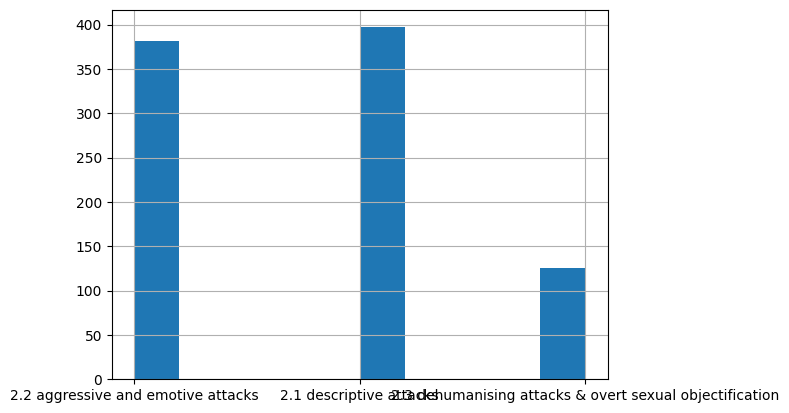

In [ ]:
import matplotlib.pyplot as plt

taskC2_train['label_vector'].hist()
plt.show()

In [ ]:
labels = np.unique(taskC2_train['label_vector'])
labels

array(['2.1 descriptive attacks', '2.2 aggressive and emotive attacks',
       '2.3 dehumanising attacks & overt sexual objectification'],
      dtype=object)

In [ ]:
label_map = {x:i for i,x in enumerate(labels)}

train_df = pd.DataFrame()
train_df['text'] = taskC2_train['text']
train_df['label'] = taskC2_train['label_vector'].map(label_map)

val_df = pd.DataFrame()
val_df['text'] = taskC2_val['text']
val_df['label'] = taskC2_val['label_vector'].map(label_map)

In [ ]:
len(train_df), len(val_df)

(903, 218)

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(train_df),
                      'val': Dataset.from_pandas(val_df)})

In [ ]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizerC2 = AutoTokenizer.from_pretrained("roberta-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

In [ ]:
def preprocess_function(examples):
    return tokenizerC2(examples["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

  0%|          | 0/903 [00:00<?, ?ex/s]

  0%|          | 0/218 [00:00<?, ?ex/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizerC2)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
modelC2 = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading 

In [ ]:
import evaluate
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_preds):
    # metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(predictions,labels, average='weighted')
    acc = accuracy_score(predictions,labels)
    return {'f1':f1, 'acc':acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="drive/MyDrive/Project6/Task_C/Part_2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainerC2 = Trainer(
    model=modelC2,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizerC2,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainerC2.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 903
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 285
  Number of trainable parameters = 124647939
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.750627,0.695829,0.669725
2,No log,0.633978,0.774614,0.747706
3,No log,0.658353,0.763221,0.766055
4,No log,0.685514,0.749192,0.752294
5,No log,0.677004,0.762451,0.766055


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 218
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 218
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.f

TrainOutput(global_step=285, training_loss=0.5904228879694353, metrics={'train_runtime': 63.851, 'train_samples_per_second': 70.712, 'train_steps_per_second': 4.464, 'total_flos': 136315361692440.0, 'train_loss': 0.5904228879694353, 'epoch': 5.0})

In [ ]:
trainerC2.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 218
  Batch size = 16


{'eval_loss': 0.6770039200782776,
 'eval_f1': 0.762451352143694,
 'eval_acc': 0.7660550458715596,
 'eval_runtime': 0.7811,
 'eval_samples_per_second': 279.105,
 'eval_steps_per_second': 17.924,
 'epoch': 5.0}

In [ ]:
predictions = trainerC2.predict(tokenized_dataset["val"])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 218
  Batch size = 16


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(predictions.label_ids, preds))
print('F1_score =', f1_score(predictions.label_ids, preds, average='weighted'))
print('Accuracy_score =', accuracy_score(predictions.label_ids, preds))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       112
           1       0.75      0.82      0.78        89
           2       0.35      0.41      0.38        17

    accuracy                           0.77       218
   macro avg       0.65      0.67      0.66       218
weighted avg       0.78      0.77      0.77       218

F1_score = 0.7696587395994253
Accuracy_score = 0.7660550458715596


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

train_df0 = train_df[train_df['label']==0]
try:
    train_df0 = train_df0.drop(['level_0'], axis=1)
except:
    pass
train_df0 = train_df0.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df0['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df0['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df1 = train_df[train_df['label']==1]
try:
    train_df1 = train_df1.drop(['level_0'], axis=1)
except:
    pass
train_df1 = train_df1.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df1['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df1['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df2 = train_df[train_df['label']==2]
try:
    train_df2 = train_df2.drop(['level_0'], axis=1)
except:
    pass
train_df2 = train_df2.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df2['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df2['label'][i]))
    except:
        continue

Weights given to word:
[('stuck', 0.3646760759523095), ('##s', 0.17048143473979602), ('own', 0.16486520724169706), ('.', 0.12447686554304427), ('money', 0.10819688038703833), ('or', 0.07385537033041345), ('it', 0.054810587457136344), ('ignore', 0.041384187312008984), (',', 0.030438959779482376), ('just', 0.030183394669922075)]
Class - 0
Weights given to word:
[('willing', 0.2594300670313454), ('they', 0.19839074242115093), ('to', 0.14519211303512009), ('even', 0.12492303885351139), ('t', 0.12279981901012192), ('help', 0.10987587772985019), ('same', 0.08256185020094114), ('to', 0.060423092980056825), ('any', 0.05641131656471876), ('’', 0.05600624634247164)]
Class - 0
Weights given to word:
[('.', 0.3175031913518222), ('power', 0.16329699169285053), ('block', 0.14335188915942673), ('own', 0.13738672928831877), ('college', 0.06211854795595864), ('go', 0.046490613478400354), ('your', 0.03068815741634744), ('and', 0.023421620064503535), ('way', 0.015383329356685129), ('the', 0.0093195943867

## Part 3

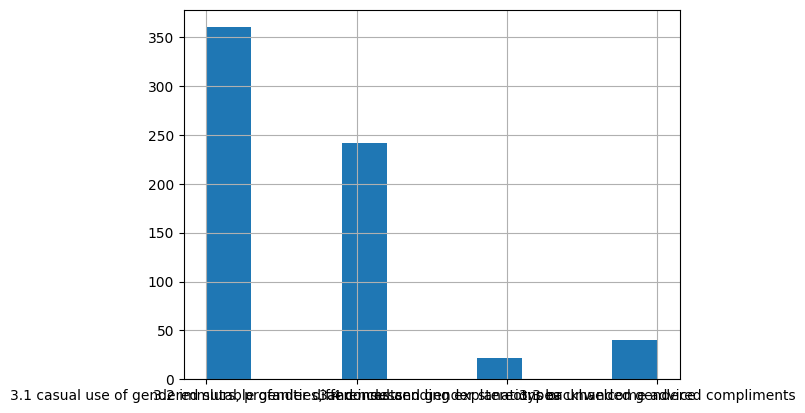

In [ ]:
import matplotlib.pyplot as plt

taskC3_train['label_vector'].hist()
plt.show()

In [ ]:
labels = np.unique(taskC3_train['label_vector'])
labels

array(['3.1 casual use of gendered slurs, profanities, and insults',
       '3.2 immutable gender differences and gender stereotypes',
       '3.3 backhanded gendered compliments',
       '3.4 condescending explanations or unwelcome advice'], dtype=object)

In [ ]:
label_map = {x:i for i,x in enumerate(labels)}

taskC3_df = pd.DataFrame()
taskC3_df['text'] = taskC3_train['text']
taskC3_df['label'] = taskC3_train['label_vector'].map(label_map)

In [ ]:
len(train_df), len(val_df)

(903, 218)

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(train_df),
                      'val': Dataset.from_pandas(val_df)})

In [ ]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizerC3 = AutoTokenizer.from_pretrained("roberta-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

In [ ]:
def preprocess_function(examples):
    return tokenizerC3(examples["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

  0%|          | 0/903 [00:00<?, ?ex/s]

  0%|          | 0/218 [00:00<?, ?ex/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizerC3)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
modelC3 = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": t

In [ ]:
import evaluate
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_preds):
    # metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(predictions,labels, average='weighted')
    acc = accuracy_score(predictions,labels)
    return {'f1':f1, 'acc':acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="drive/MyDrive/Project6/Task_C/Part_3",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainerC3 = Trainer(
    model=modelC3,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizerC3,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainerC3.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 903
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 285
  Number of trainable parameters = 124648708
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.737001,0.743163,0.711009
2,No log,0.664487,0.779149,0.752294
3,No log,0.701687,0.758710,0.756881
4,No log,0.751892,0.743033,0.747706
5,No log,0.723404,0.745987,0.747706


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 218
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 218
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.f

TrainOutput(global_step=285, training_loss=0.5999038428591009, metrics={'train_runtime': 63.6481, 'train_samples_per_second': 70.937, 'train_steps_per_second': 4.478, 'total_flos': 136316585602080.0, 'train_loss': 0.5999038428591009, 'epoch': 5.0})

In [ ]:
trainerC3.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 218
  Batch size = 16


{'eval_loss': 0.7234042882919312,
 'eval_f1': 0.7459871193224256,
 'eval_acc': 0.7477064220183486,
 'eval_runtime': 0.7783,
 'eval_samples_per_second': 280.083,
 'eval_steps_per_second': 17.987,
 'epoch': 5.0}

In [ ]:
predictions = trainerC3.predict(tokenized_dataset["val"])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 218
  Batch size = 16


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(predictions.label_ids, preds))
print('F1_score =', f1_score(predictions.label_ids, preds, average='weighted'))
print('Accuracy_score =', accuracy_score(predictions.label_ids, preds))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       112
           1       0.73      0.80      0.76        89
           2       0.33      0.35      0.34        17

    accuracy                           0.75       218
   macro avg       0.63      0.64      0.64       218
weighted avg       0.75      0.75      0.75       218

F1_score = 0.7494257247142717
Accuracy_score = 0.7477064220183486


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

train_df0 = train_df[train_df['label']==0]
try:
    train_df0 = train_df0.drop(['level_0'], axis=1)
except:
    pass
train_df0 = train_df0.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df0['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df0['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df1 = train_df[train_df['label']==1]
try:
    train_df1 = train_df1.drop(['level_0'], axis=1)
except:
    pass
train_df1 = train_df1.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df1['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df1['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df2 = train_df[train_df['label']==2]
try:
    train_df2 = train_df2.drop(['level_0'], axis=1)
except:
    pass
train_df2 = train_df2.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df2['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df2['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df3 = train_df[train_df['label']==3]
try:
    train_df3 = train_df3.drop(['level_0'], axis=1)
except:
    pass
train_df3 = train_df3.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df3['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df3['label'][i]))
    except:
        continue

Weights given to word:
[('stuck', 0.3646760759523095), ('##s', 0.17048143473979602), ('own', 0.16486520724169706), ('.', 0.12447686554304427), ('money', 0.10819688038703833), ('or', 0.07385537033041345), ('it', 0.054810587457136344), ('ignore', 0.041384187312008984), (',', 0.030438959779482376), ('just', 0.030183394669922075)]
Class - 0
Weights given to word:
[('willing', 0.2594300670313454), ('they', 0.19839074242115093), ('to', 0.14519211303512009), ('even', 0.12492303885351139), ('t', 0.12279981901012192), ('help', 0.10987587772985019), ('same', 0.08256185020094114), ('to', 0.060423092980056825), ('any', 0.05641131656471876), ('’', 0.05600624634247164)]
Class - 0
Weights given to word:
[('.', 0.3175031913518222), ('power', 0.16329699169285053), ('block', 0.14335188915942673), ('own', 0.13738672928831877), ('college', 0.06211854795595864), ('go', 0.046490613478400354), ('your', 0.03068815741634744), ('and', 0.023421620064503535), ('way', 0.015383329356685129), ('the', 0.0093195943867

## Part 4

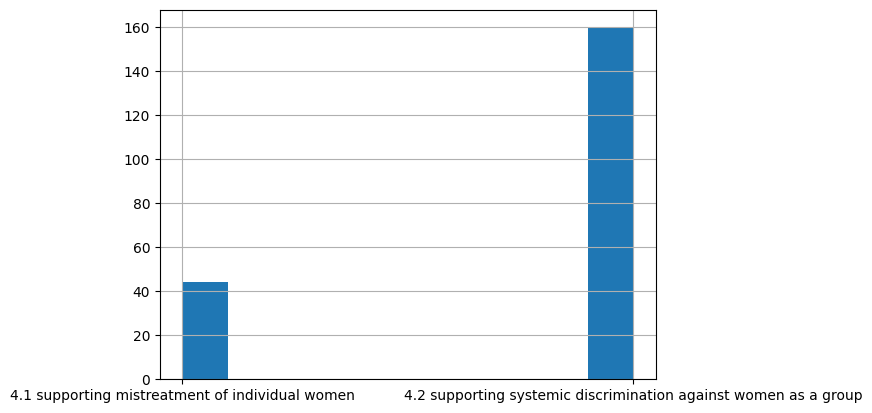

In [ ]:
import matplotlib.pyplot as plt

taskC4_train['label_vector'].hist()
plt.show()

In [ ]:
labels = np.unique(taskC4_train['label_vector'])
labels

array(['4.1 supporting mistreatment of individual women',
       '4.2 supporting systemic discrimination against women as a group'],
      dtype=object)

In [ ]:
label_map = {x:i for i,x in enumerate(labels)}

train_df = pd.DataFrame()
train_df['text'] = taskC4_train['text']
train_df['label'] = taskC4_train['label_vector'].map(label_map)

val_df = pd.DataFrame()
val_df['text'] = taskC4_val['text']
val_df['label'] = taskC4_val['label_vector'].map(label_map)

In [ ]:
len(train_df), len(val_df)

(204, 47)

In [ ]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(train_df),
                      'val': Dataset.from_pandas(val_df)})

In [ ]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizerC4 = AutoTokenizer.from_pretrained("roberta-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

In [ ]:
def preprocess_function(examples):
    return tokenizerC4(examples["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

  0%|          | 0/204 [00:00<?, ?ex/s]

  0%|          | 0/47 [00:00<?, ?ex/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizerC4)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
modelC4 = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/pytorch_

In [ ]:
import evaluate
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_preds):
    # metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(predictions,labels, average='weighted')
    acc = accuracy_score(predictions,labels)
    return {'f1':f1, 'acc':acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="drive/MyDrive/Project6/Task_C/Part_4",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainerC4 = Trainer(
    model=modelC4,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizerC4,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainerC4.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 204
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 65
  Number of trainable parameters = 124647170
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.647772,0.839506,0.723404
2,No log,0.590014,0.839506,0.723404
3,No log,0.594637,0.839506,0.723404
4,No log,0.507878,0.839506,0.723404
5,No log,0.478301,0.839506,0.723404


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.for

TrainOutput(global_step=65, training_loss=0.49474334716796875, metrics={'train_runtime': 14.667, 'train_samples_per_second': 69.544, 'train_steps_per_second': 4.432, 'total_flos': 31073826749040.0, 'train_loss': 0.49474334716796875, 'epoch': 5.0})

In [ ]:
trainerC4.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 16


{'eval_loss': 0.47830134630203247,
 'eval_f1': 0.8395061728395062,
 'eval_acc': 0.723404255319149,
 'eval_runtime': 0.1777,
 'eval_samples_per_second': 264.428,
 'eval_steps_per_second': 16.878,
 'epoch': 5.0}

In [ ]:
predictions = trainerC4.predict(tokenized_dataset["val"])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 47
  Batch size = 16


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(predictions.label_ids, preds))
print('F1_score =', f1_score(predictions.label_ids, preds, average='weighted'))
print('Accuracy_score =', accuracy_score(predictions.label_ids, preds))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.72      1.00      0.84        34

    accuracy                           0.72        47
   macro avg       0.36      0.50      0.42        47
weighted avg       0.52      0.72      0.61        47

F1_score = 0.6073023377987917
Accuracy_score = 0.723404255319149


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

train_df0 = train_df[train_df['label']==0]
try:
    train_df0 = train_df0.drop(['level_0'], axis=1)
except:
    pass
train_df0 = train_df0.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df0['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df0['label'][i]))
    except:
        continue

print("--------------------------------------------------------------------")

train_df1 = train_df[train_df['label']==1]
try:
    train_df1 = train_df1.drop(['level_0'], axis=1)
except:
    pass
train_df1 = train_df1.reset_index()
for i in range(5):
    try:
        multiclass_explainer = SequenceClassificationExplainer(model=modelA, tokenizer=tokenizerA)
        sample_text = train_df1['text'][i]
        word_attributes = multiclass_explainer(text = sample_text)

        most_weighted_words = list(sorted(word_attributes, key=lambda item: item[1], reverse = True))[:10]
        print("Weights given to word:")
        print(most_weighted_words)
        print("Class - {}".format(train_df1['label'][i]))
    except:
        continue

Weights given to word:
[('ass', 0.5628025474670685), ('they', 0.2505218207390498), ('assault', 0.24234352410082538), ('for', 0.20099386737998173), ('sexual', 0.10101130522997166), ('it', 0.09267944421374433), ('##cala', 0.08619361897428227), ('es', 0.04970991518594071), ('joke', 0.02793408664645275), ('an', 0.022294258546960002)]
Class - 0
Weights given to word:
[('-', 0.14764337481038475), ('boyfriend', 0.14029795220703054), ('retro', 0.11306314302638676), ('you', 0.10773278156881663), ('i', 0.10539392164708127), ('openly', 0.07101070757082902), ('"', 0.04894343382162066), ('##active', 0.04867705034329936), ('idea', 0.04042127530117023), ('consent', 0.038873051977680304)]
Class - 0
Weights given to word:
[('men', 0.6617212988532623), ('woman', 0.4362594608340169), ('rape', 0.3410183291736224), ('unless', 0.23260234032764276), ('are', 0.16380559437509942), ('a', 0.14773848803366837), ('avoiding', 0.12513796996539245), ('because', 0.12038199213415417), ('considered', 0.11443479478801144

# The End